In [ ]:
import torch
import torch.nn as nn


class VideoTokenizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(48, 128, 1, 1, 0)

    def _split_into_patches(self, frame: torch.Tensor):
        """Split a 64x64 frame into 4x4 grid of 16x16 patches.
        
        Args:
            frame: Tensor of shape (B, H, W, C) where H=W=64
        """
        batch_no, height, width, channels = frame.shape
        pizza_boxes = frame.reshape(batch_no, 4, 16, 4, 16, 3).permute(0, 1, 3, 2, 4, 5) # 4,4,16,16,3
        stack_the_boxes = pizza_boxes.permute(0,1,2,5,3,4).reshape(batch_no, 48, 16, 16) # 48,16,16

        return stack_the_boxes

    def forward(self, x: torch.Tensor):
        x = self._split_into_patches(x)
        x = self.conv(x)
        return x

        

In [ ]:
class SpaceTimeTransformer(nn.Module):
    def __init__(self):
        pass

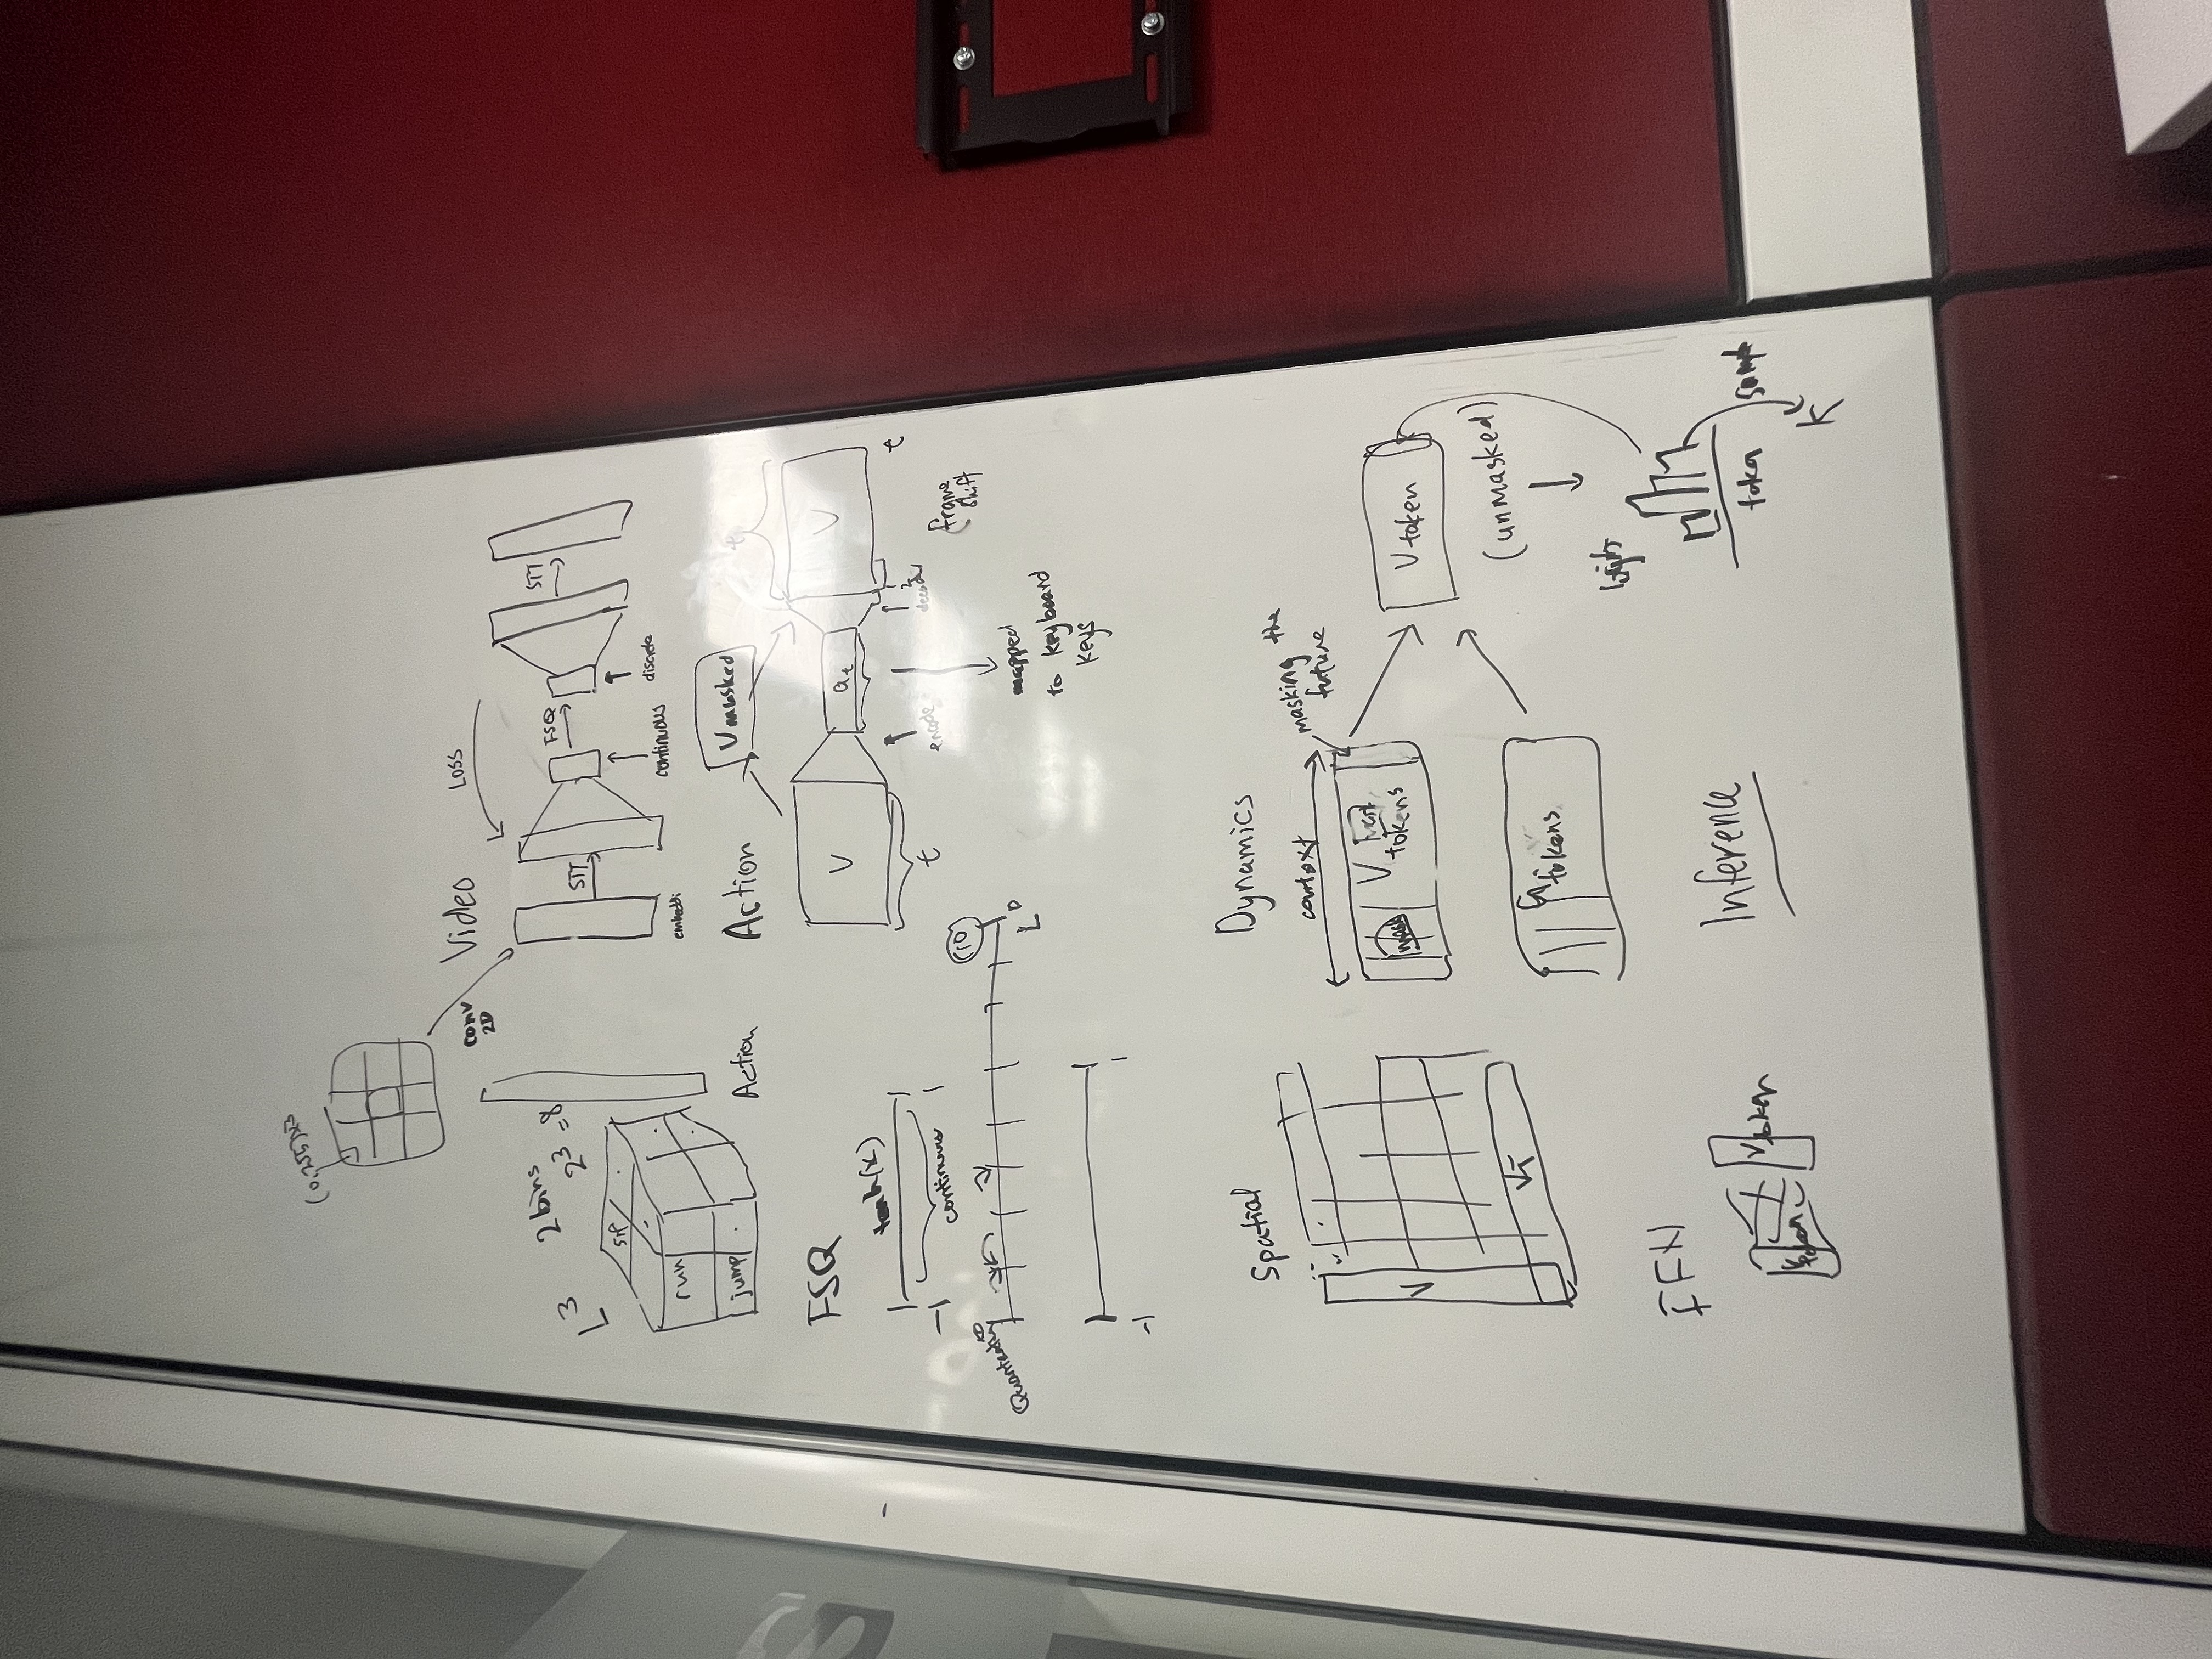

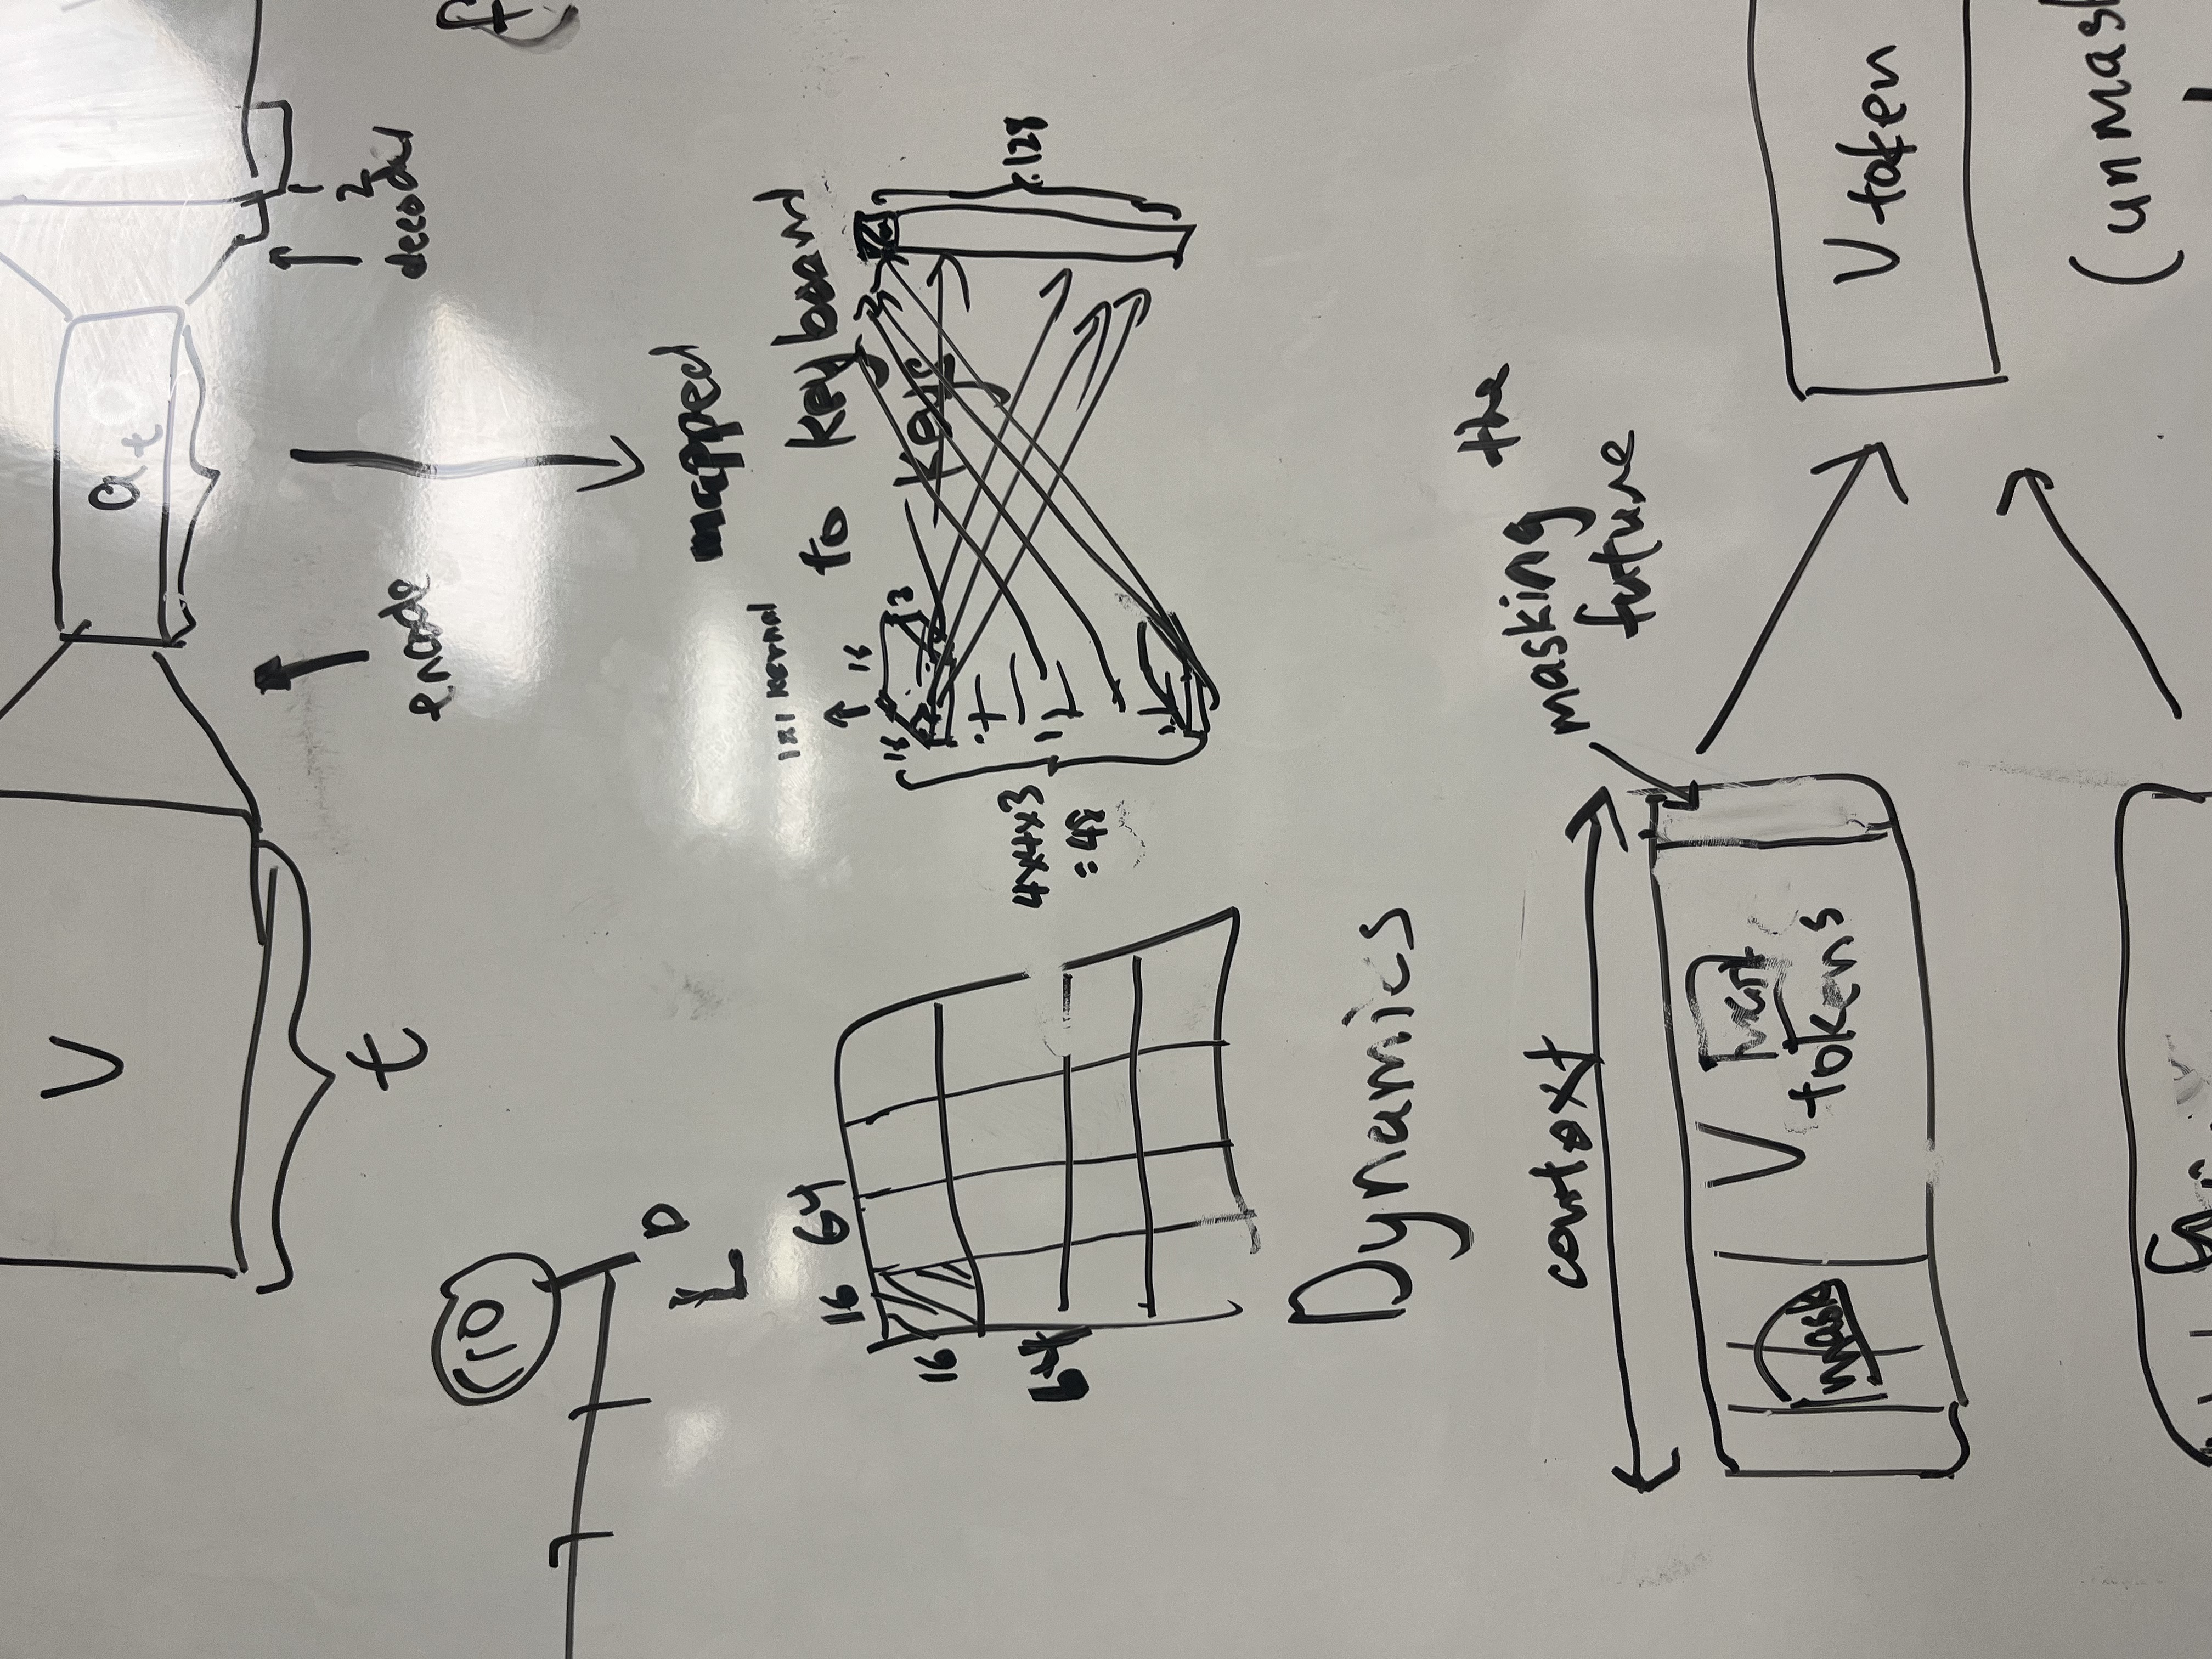

In [22]:
frame.shape

(64, 64, 3)

Keys in the H5 file: ['frames']

Structure of 'frames':
  Shape: (5385, 64, 64, 3)
  Dtype: uint8


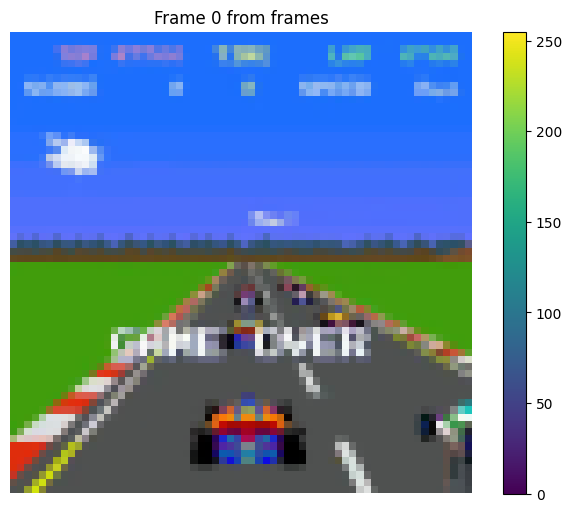

In [5]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

# Open the H5 file
h5_path = '../data/pole_position_frames.h5'

with h5py.File(h5_path, 'r') as f:
    print("Keys in the H5 file:", list(f.keys()))
    # Get the first key to explore structure
    if len(f.keys()) > 0:
        first_key = list(f.keys())[0]
        print(f"\nStructure of '{first_key}':")
        print(f"  Shape: {f[first_key].shape}")
        print(f"  Dtype: {f[first_key].dtype}")
        
        # Load and display the first frame
        frame = f[first_key][0]  # Get the first frame
        
        plt.figure(figsize=(8, 6))
        plt.imshow(frame)
        plt.title(f"Frame 0 from {first_key}")
        plt.axis('off')
        plt.colorbar()
        plt.show()

# Understanding reshape and permute
https://gemini.google.com/share/28f4246372f6

your torch tensor is stored in 1D memory. and pytorch flattens it by taking the rows, and placing them side by side of each other.
so 64x64, you take 64 lines of pixels, and line them up beside each other.

when you reshape, it pytorch takes the start of the line and fills in from the innermost array. so like 64x4x16, it will take a 16 pixel chunk from the line, and fill it into the 16 pixel array in dim 2. then it will take the next 16 pixel array, and stack it below etc.

therefore, when you want to reshape something into patches, the shape should always specify the widths last in the new shape, it fills it in horizontally, so to follow the same order on the 1D line, you define where it should cut horizontally. 

but if you want patches, you can't have very long rows. you wanna have square patches.

so you use permute. permute basically tells pytorch how may indices to skip to retrieve the index at that dimension. so if you have 16 items in your row. then to go to the next row, means you need to jump ahead by 16 items in the 1D array.

to give a concrete example, for 64x64x3, we first reshape it into 4x16x4x16x3 (4x16) are the 4 x horizontal patch + 16 horizontal pixels in each patch. and the same for vertical. but we put the horizontal dimensions last. what you get here is long slices 64 pixel lines but have 3 slices between. so when pytorch reads the array, it will read along that long horizontal line. but because we want patches, to read the 1D representation of a patch, we read the first 16 pixels of that long line, then we need to jump to the next line, can get the next 16 pixels. so because the line is 64 long, that means we need to jump forward by 64 along the 1D array. 

In [2]:
import sys
from pathlib import Path

# Add the parent directory to Python path so we can import from utils
sys.path.insert(0, str(Path.cwd().parent))

from utils.notmonad import chain, loop

In [21]:
(chain(frame)
 (torch.from_numpy)
#  (lambda x: x.permute(2,0,1))
#  (lambda x: x.reshape(-1,16, 3)) # get a tall stack of 1x16 pixels by going horizontally and picking up 16 pixels lines and stack them on top of another
 (lambda x: x.reshape(4,16,4,16,3)) # line 4 x 16 pixels lines into one line to get back 64 pixels, and then stack the 64 pixels lines on top of each other, but separate every 16 lines
#  (lambda x: x.permute(0,2,1,3,4))
#  (lambda x: x.permute(0,1,4,2,3)) # put the color channel in front so that we can do conv2d later
#  (lambda x: x.reshape(48, 16, 16))
#  (lambda x: x[3:6].permute(1,2,0))
#  (loop, lambda x: chain(x)(loop, plt.imshow)(lambda x: plt.show())())
#  (plt.imshow)
 (lambda x: x.shape)
 ())



torch.Size([4, 16, 4, 16, 3])